### TransUNet 대상

In [1]:
import torch
import matplotlib.pyplot as plt
from utils.util import *
from utils.custom_dataset import *
torch.backends.cudnn.enabled = False

### 0. 데이터확인

In [2]:
PreprocessObj = PreprocessData()
PreprocessObj.get_solve_array()
PreprocessObj.scaling_and_resize()

100%|██████████| 550/550 [00:04<00:00, 133.40it/s]


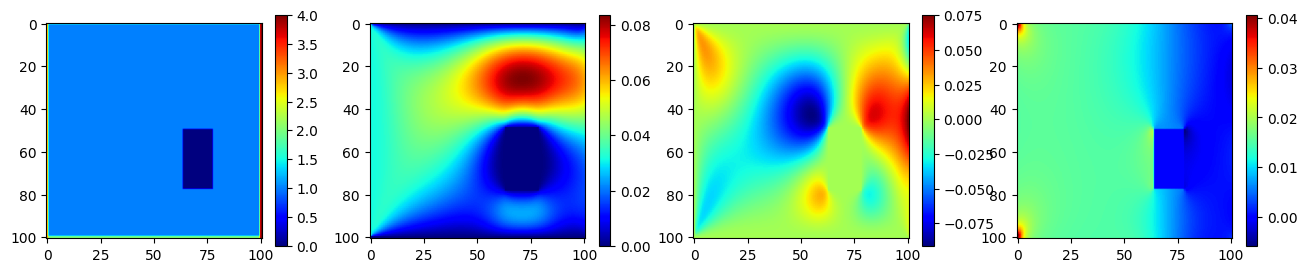

In [3]:
plot_idx = 0 
plt.figure(figsize=[16,3])
plt.subplot(1,4,1)
plt.imshow(PreprocessObj.boundary_data[plot_idx],cmap='jet')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(PreprocessObj.ux_data[plot_idx],cmap='jet')
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(PreprocessObj.uy_data[plot_idx],cmap='jet')
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(PreprocessObj.p_data[plot_idx],cmap='jet')
plt.colorbar()

### 1. 데이터세트 로드

In [4]:
import torchvision.transforms as transforms

dataset = CustomDataset(transform=transforms.Compose([transforms.ToTensor()]),
                        target_transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 550/550 [00:03<00:00, 139.33it/s]


In [5]:
from torch.utils.data import random_split

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset,[train_size,validation_size,test_size],
                                                               generator=torch.Generator().manual_seed(42))
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 440
Validation Data Size : 55
Testing Data Size : 55


In [6]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [7]:
for a,b,d,e,f in train_dataloader:
    print(a.shape)
    print(b.shape)
    print(d.shape)
    print(e.shape)
    print(f.shape)
    break

torch.Size([4, 1, 101, 101])
torch.Size([4, 8])
torch.Size([4, 1, 101, 101])
torch.Size([4, 1, 101, 101])
torch.Size([4, 1, 101, 101])


### 2. 모델 로드

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from model.transunet_model import *
from model.unet_model import *
model = TransUNet().to(device) # 사용할 모델 지정

### 3. 학습/검증 수행

In [9]:
def train_loop(dataloader,model,loss_fn,optimizer):
    
    # 입력 데이터세트의 총 길이 
    size = len(dataloader.dataset) # 320

    # 배치 총 개수 (320/4 = 80) 
    num_batches = len(dataloader)
    
    # loss 초기화
    train_loss = 0

    # train_loop 
    for batch, (bdr,opr,ux,uy,p) in enumerate(dataloader): 
        
        # 타입 & device 변환
        bdr = bdr.type(torch.float32).to(device)
        opr = opr.type(torch.int32).to(device)
        ux = ux.type(torch.float32).to(device)
        uy = uy.type(torch.float32).to(device)
        p = p.type(torch.float32).to(device)

        X = [bdr,opr]
        y = torch.concat([ux,uy,p],axis=1)
        
        # 모델 예측
        pred = model(X)

        # Loss 계산
        loss = loss_fn(pred,y)
    
        # Backpropagation
        optimizer.zero_grad() # 이전 루프에서 각 파라미터들에 저장된 .grad를 초기화
        loss.backward() # 각 파라미터들의 .grad값에 변화정도가 저장이 됨.
        optimizer.step() # 최적화함수에 맞게, 각 파라미터 업데이트

        # LOSS 
        train_loss += loss.item() # item()을 통해, 변수에서 값만 가져옴

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")
    
    return train_loss

def validation_loop(dataloader,model,loss_fn):

    # 입력 데이터세트의 총 길이
    size = len(dataloader.dataset) # 40
    
    # 배치 총 개수 (40/4 = 10)
    num_batches = len(dataloader)

    # loss 초기화
    validation_loss = 0

    # 테스트 단계이므로 gradient 옵션 해제
    with torch.no_grad():
        for bdr,opr,ux,uy,p in dataloader:
            
            # 타입 & device 변환
            bdr = bdr.type(torch.float32).to(device)
            opr = opr.type(torch.int32).to(device)
            ux = ux.type(torch.float32).to(device)
            uy = uy.type(torch.float32).to(device)
            p = p.type(torch.float32).to(device)

            X = [bdr,opr]
            y = torch.concat([ux,uy,p],axis=1)
            
            # 모델 예측
            pred = model(X)
            
            # Loss 계산
            loss = loss_fn(pred,y)

            # LOSS 
            validation_loss += loss.item() # item()을 통해, 변수에서 값만 가져옴
    
    validation_loss /= num_batches
    
    print(f"Validation loss: {validation_loss:>8f}")

    return validation_loss

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        초기화 함수
        patience: 개선이 없더라도 몇 번의 에폭을 더 기다릴지 설정
        min_delta: 개선이라고 간주될 최소 손실 변화량
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, validation_loss):
        # 첫 에폭이거나 손실이 개선된 경우
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss < self.best_loss - self.min_delta:
            # 손실이 개선된 경우, 최적의 손실 업데이트 및 카운터 초기화
            self.best_loss = validation_loss
            self.counter = 0
        else:
            # 개선되지 않은 경우 카운터 증가
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered after {self.counter} epochs with no improvement.")
                self.early_stop = True

In [11]:
patience = 30  # patience는 원하는 만큼 조정
early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
learning_rate = 1e-3
epochs = 400
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
train_loss_all = []
validation_loss_all = []

for t in range(epochs):
    # Train Loop
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss_all.append(train_loss)
    
    # Validation Loop
    validation_loss = validation_loop(validation_dataloader, model, loss_fn)
    validation_loss_all.append(validation_loss)

    # # Early Stopping 체크
    # early_stopping(validation_loss)
    # if early_stopping.early_stop:
    #     print(f"Early stopping at epoch {t+1}")
    #     break
    
print("학습완료")

Train loss: 0.070188
Validation loss: 0.058235
Train loss: 0.049610
Validation loss: 0.056030
Train loss: 0.044385
Validation loss: 0.040853
Train loss: 0.037920
Validation loss: 0.041381
Train loss: 0.040739
Validation loss: 0.039199
Train loss: 0.036831
Validation loss: 0.039044
Train loss: 0.034408
Validation loss: 0.036959
Train loss: 0.036337
Validation loss: 0.033839
Train loss: 0.033268
Validation loss: 0.031057
Train loss: 0.030351
Validation loss: 0.036137
Train loss: 0.032597
Validation loss: 0.033288
Train loss: 0.029130
Validation loss: 0.035641
Train loss: 0.028706
Validation loss: 0.025232
Train loss: 0.026067
Validation loss: 0.027036
Train loss: 0.031244
Validation loss: 0.033085
Train loss: 0.027890
Validation loss: 0.026652
Train loss: 0.026046
Validation loss: 0.026102
Train loss: 0.023089
Validation loss: 0.023537
Train loss: 0.023435
Validation loss: 0.025772
Train loss: 0.023271
Validation loss: 0.024474
Train loss: 0.022748
Validation loss: 0.021829
Train loss: 0

결과저장 & 결과확인

In [12]:
TEST_NUM = 1
model_name = "TransUNet"
save_model_name = f'checkpoints/{model_name}_CFD_test{TEST_NUM}.pth'
train_log_name = f'logs/{model_name}_test{TEST_NUM}_train_loss.npy'
validation_log_name = f'logs/{model_name}_test{TEST_NUM}_validation_loss.npy' 

# 가중치 저장 또는 로드
if os.path.isfile(save_model_name):
    print("이미 가중치가 존재합니다. 가중치를 가져옵니다.")
    model.load_state_dict(torch.load(save_model_name))
else:
    print("가중치를 저장합니다.")
    torch.save(model.state_dict(),save_model_name)

# 로그 저장 또는 로드
if os.path.isfile(train_log_name):
    print("이미 학습 로그가 존재합니다. 해당 결과를 가져옵니다.")
    train_loss_all_arr = np.load(train_log_name)
else:
    print("학습 로그를 저장합니다.")
    train_loss_all_arr = np.array(train_loss_all)
    np.save(train_log_name,train_loss_all_arr)
if os.path.isfile(validation_log_name):
    print("이미 검증 로그가 존재합니다. 해당 결과를 가져옵니다.")
    validation_loss_all_arr = np.load(validation_log_name)
else:
    print("검증 로그를 저장합니다.")
    validation_loss_all_arr = np.array(validation_loss_all)
    np.save(validation_log_name,validation_loss_all_arr)

가중치를 저장합니다.
학습 로그를 저장합니다.
검증 로그를 저장합니다.


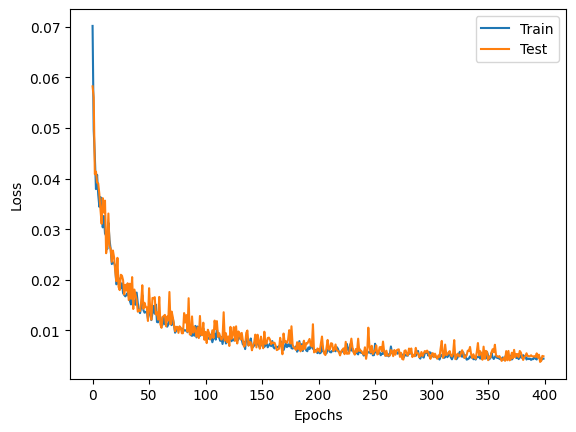

In [13]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss_all_arr,label='Train')
plt.plot(validation_loss_all_arr,label='Test')
plt.legend()

### 4. 테스트

In [14]:
test_loss = 0
num_batches = len(test_dataloader)
print(num_batches)
bdr_lst = []
label_lst = []
pred_lst = []


for bdr,opr,ux,uy,p in tqdm(test_dataloader):

    # 타입 & device 변환
    bdr = bdr.type(torch.float32).to(device)
    opr = opr.type(torch.int32).to(device)
    ux = ux.type(torch.float32).to(device)
    uy = uy.type(torch.float32).to(device)
    p = p.type(torch.float32).to(device)

    X = [bdr,opr]
    y = torch.concat([ux,uy,p],axis=1)
    
    # 모델 예측
    pred = model(X)
    
    bdr = bdr.to('cpu')
    opr = opr.to('cpu')
    y = y.to('cpu')
    pred = pred.to('cpu')

    bdr_lst.append(bdr)
    label_lst.append(y)
    pred_lst.append(pred)

    # Loss 계산
    loss = loss_fn(pred,y)

    # LOSS 
    test_loss += loss.item() # item()을 통해, 변수에서 값만 가져옴

14


100%|██████████| 14/14 [00:00<00:00, 113.37it/s]


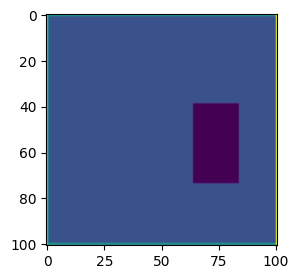

In [15]:
batch_num = 3
plt.figure(figsize=[8,3])
plt.imshow(bdr_lst[0][batch_num][0].detach().numpy())

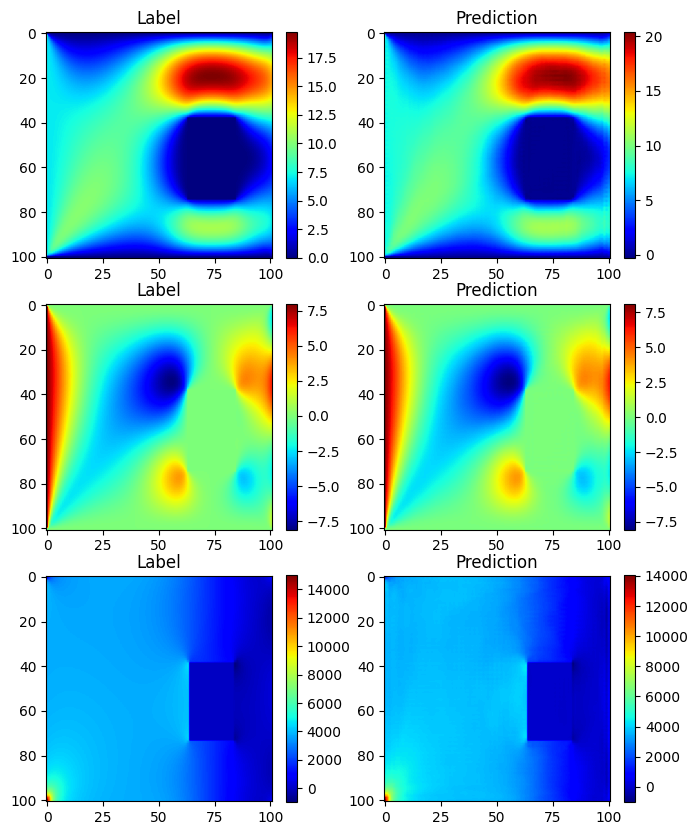

In [16]:
plot_dic = {0:PreprocessObj.DataConfig.ux_max,
            1:PreprocessObj.DataConfig.uy_max,
            2:PreprocessObj.DataConfig.p_max}
plot_subject = 0
plt.figure(figsize=[8,10])
for idx in [1,3,5]:
    plt.subplot(3,2,idx)
    plt.imshow(label_lst[0][batch_num][plot_subject].detach().numpy()*plot_dic[plot_subject],cmap='jet')
    plt.title('Label')
    plt.colorbar()
    plt.subplot(3,2,idx+1)
    plt.imshow(pred_lst[0][batch_num][plot_subject].detach().numpy()*plot_dic[plot_subject],cmap='jet')
    plt.title('Prediction')
    plt.colorbar()
    plot_subject += 1